In [39]:
# Importing libraries and modules
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("SDEutils.jl")
using .SDEutils, Plots, Statistics, Distributions, KernelDensity, StatsBase, LinearAlgebra, LaTeXStrings

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Biochemical Reaction Kinetics for Bioethanol Production

In [40]:
# Setting up the model parameters
# The parameters are defined in a dictionary for easy access and modification
params  = Dict(
    "μ_max" => 0.244, # Zentou et al 
    "K_sx" => 11.55, # Zentou et al
    "Y_xs" => 0.28, # Zentou et al
    "Y_ys" => 0.42, # Zentou et al
    "m_s" => 0.015, # Villadsen
    "q_max_y" => 1.79, # Nagy
    "K_sy" => 1.68, # Nagy
    "q_max_z" => 0.042*1.79, # Nagy
    "K_sz" => 0.1, # Zentou et al
    "σs" => 1.0, # Arbitrary
    "σx" => 1.0, # Arbitrary
    "σy" => 1.0, # Arbitrary
    "σz" => 1.0 # Arbitrary
)

# Initial conditions for the state variables
# The initial conditions are defined in a dictionary for easy access and modification
init = Dict(
    "S0" => 25.0, 
    "X0" => 2.0, 
    "Y0" => 0.0,
    "Z0" => 0.0
)

# Time parameters
T = 25.0  # Time span for the simulation
dt = 0.01  # Time step for the simulation
tsteps = 0:dt:T  # Time steps array
N = length(tsteps)  # Number of time steps

# Running the Monte Carlo simulation
M = 1_000  # Number of Monte Carlo simulations
noise = "normal" # Type of noise for the SDEs ("lognormal", "normal", or "monod")
sdesol = simulate_paths(params, T, init, M, noise, dt)[1]
odesol = simulate_paths(params, T, init, M, noise, dt)[2]
time = odesol.t  # Time vector from the ODE solution

# Storing the results in matrices for each state variable
S = zeros(length(sdesol), length(sdesol[1].t))
X = zeros(length(sdesol), length(sdesol[1].t))
Y = zeros(length(sdesol), length(sdesol[1].t))
Z = zeros(length(sdesol), length(sdesol[1].t))

for i in 1:length(sdesol)
    S[i, :] = sdesol[i][1, :]
    X[i, :] = sdesol[i][2, :]
    Y[i, :] = sdesol[i][3, :]
    Z[i, :] = sdesol[i][4, :]
end

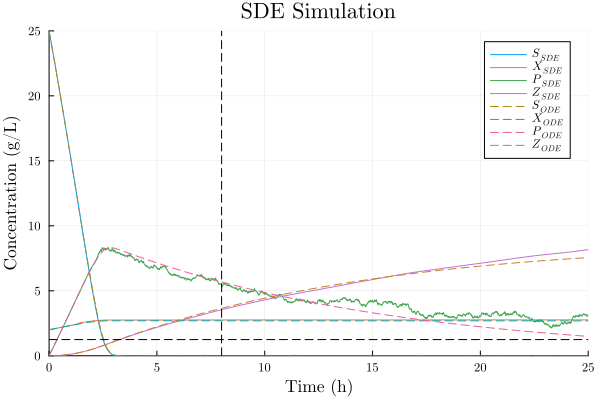

In [41]:
# Plotting the results 
plot(sdesol[1], label=[L"S_{SDE}" L"X_{SDE}" L"P_{SDE}" L"Z_{SDE}"],  title="SDE Simulation", xlabel="Time (h)", ylabel="Concentration (g/L)")
# plot!(sdesol[50], label=[L"S_{SDE2}" L"X_{SDE2}" L"P_{SDE2}" L"Z_{SDE2}"], title="SDE Simulation", xlabel="Time (h)", ylabel="Concentration (g/L)")
# plot!(sdesol[150], label=[L"S_{SDE3}" L"X_{SDE3}" L"P_{SDE3}" L"Z_{SDE3}"], title="SDE Simulation", xlabel="Time (h)", ylabel="Concentration (g/L)")
plot!(odesol, title="SDE Simulation", label=[L"S_{ODE}" L"X_{ODE}" L"P_{ODE}" L"Z_{ODE}"], xlabel="Time (h)", ylabel="Concentration (g/L)", linestyle=:dash)
plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["S0"]), xlims=(0,T))
hline!([0.05 * init["S0"]], label="", linestyle=:dash, color=:black)
vline!([8.0], label="", linestyle=:dash, color=:black)

### Longstaff-Schwartz Global Parameters

In [42]:
# 0) Some parameters:
degree = 3  # Degree of the Laguerre polynomial
thresh = 0.05 * init["S0"]  # Threshold for in-the-money paths

1.25

### Longstaff-Schwartz for Maximum Product Concentration

In [43]:
# Store stopping times
τ = fill(length(tsteps), M)

# Initialize matrices for Longstaff-Schwartz
V = copy(Y) 
degree = 3  # Degree of polynomial basis
β_matrix = zeros(N, degree + 1)

# Longstaff-Schwartz backward induction in time
for n in (length(tsteps)-1):-1:2
    y_now = Y[:, n]
    value_future = V[:, n+1]

    # Optional: Filter out non-positive values (in-the-money paths for options)
    # all of the values are supposed to be positive
    itm_indices = findall(y -> y > 0, y_now)
    if length(itm_indices) < 10
        continue
    end

    y_itm = y_now[itm_indices]
    vf_itm = value_future[itm_indices]

    # Fit polynomial regression using Laguerre basis functions
    Φ = laguerre_design_matrix(y_itm, degree)
    β = Φ \ vf_itm
    
    # Compute continuation value
    # Note: This is where the polynomial regression is used to compute the continuation value
    continuation_value = Φ * β
    stop_now = y_itm .> continuation_value

    # Update stopping times
    # Note: This is where we update the stopping times based on the stopping condition
    for (idx, stop) in zip(itm_indices, stop_now)
        if stop
            V[idx,n] = y_now[idx]
            τ[idx] = min(τ[idx], n)
        else
            V[idx,n] = V[idx,n+1]
        end
    end

    # Save regression coefficients
    β_matrix[n, :] .= β

end

# Compile outputs
Y_opt_values = [Y[i, τ[i]] for i in 1:M]
τ_times = [tsteps[τ[i]] for i in 1:M]

1000-element Vector{Float64}:
 8.36
 8.36
 8.36
 8.34
 8.34
 8.31
 8.36
 8.36
 8.36
 8.36
 ⋮
 8.34
 8.36
 8.33
 8.31
 8.36
 8.36
 8.36
 8.31
 8.34

Estimated optimal expected value of Y: 8.3366
Expected optimal stopping time: 8.3165 seconds
Variance of stopping time: 0.0034 seconds^2
Standard deviation of stopping time: 0.0587 seconds
95% confidence interval for stopping time: 8.16 to 8.36 seconds
95% confidence interval for expected value of Y: 7.5263 to 9.1343


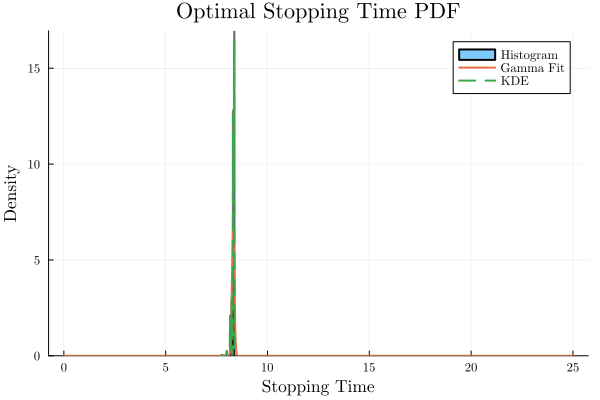

In [48]:
println("Estimated optimal expected value of Y: ", round(mean(Y_opt_values), digits=4))
println("Expected optimal stopping time: ", round(mean(τ_times), digits=4), " seconds")
println("Variance of stopping time: ", round(var(τ_times), digits=4), " seconds^2")
println("Standard deviation of stopping time: ", round(std(τ_times), digits=4), " seconds")
println("95% confidence interval for stopping time: ", round(quantile(τ_times, 0.025), digits=4), " to ", round(quantile(τ_times, 0.975), digits=4), " seconds")
println("95% confidence interval for expected value of Y: ", round(quantile(Y_opt_values, 0.025), digits=4), " to ", round(quantile(Y_opt_values, 0.975), digits=4))

# Plot: Histogram + Gamma fit + KDE
histogram(τ_times, bins=30, normalize=true, label="Histogram", xlabel="Stopping Time", ylabel="Density", title="Optimal Stopping Time PDF", 
          legend=:topright, fontfamily="Computer Modern", lw=2, alpha=0.5)

# Gamma distribution fit
fit_gamma = fit(Gamma, τ_times)
plot!(tsteps, pdf.(fit_gamma, tsteps), lw=2, label="Gamma Fit")

# KDE overlay
kde_est = kde(τ_times)
plot!(kde_est.x, kde_est.density, lw=2, linestyle=:dash, label="KDE")

In [49]:
# # 1) Initialize matrices to store time indices and continuation values
# τ_p = fill(N, M)
# V_p = zeros(M, N)

# # 2) Assign terminal values for V_p
# for i in 1:M
#     V_p[i, N] = Y[i, N]
# end

# # 3) Backward induction to compute continuation values
# for n in (N-1):-1:1
#     y_now_p = Y[:, n]
#     value_future_p = V_p[:, n+1]

#     # Optional: Filter out non-positive values (in-the-money paths for options)
#     # all of the values are supposed to be positive
#     itm_indices_p = findall(y -> y > 0, y_now_p)
#     if length(itm_indices_p) < 10
#         continue
#     end

#     y_itm_p = y_now_p[itm_indices_p]
#     vf_itm_p = value_future_p[itm_indices_p]

#     # Fit polynomial regression using Laguerre basis functions
#     Φ_p = laguerre_design_matrix(y_itm_p, degree)
#     β_p = Φ_p \ vf_itm_p
    
#     # Compute continuation value
#     # Note: This is where the polynomial regression is used to compute the continuation value
#     continuation_value_p = Φ_p * β_p
#     stop_now_p = y_itm_p .> continuation_value_p

#     # Update stopping times
#     # Note: This is where we update the stopping times based on the stopping condition
#     for (idx, stop) in zip(itm_indices_p, stop_now_p)
#         if stop
#             V_p[idx,n] = y_now_p[idx]
#             τ_p[idx] = min(τ_p[idx], n)
#         else
#             V_p[idx,n] = V_p[idx,n+1]
#         end
#     end
# end

# # 4) Compile outputs
# Y_opt_values = [Y[i, τ_p[i]] for i in 1:M]
# τ_times_p = [tsteps[τ_p[i]] for i in 1:M]
# mean_stopping_time_p = mean(τ_times_p)
# println("Average stopping time: ", mean_stopping_time_p)

# # 5) Plotting the results
# histogram(τ_times_p;
#     bins=30,
#     xlabel="Stopping time (h)",
#     ylabel="Frequency",
#     title="Distribution of Stopping Times",
#     legend=false,
#     fontfamily="Computer Modern"
# )         

### Longstaff-Schwartz for Substrate Consumption

Average stopping time: 7.455780000000001


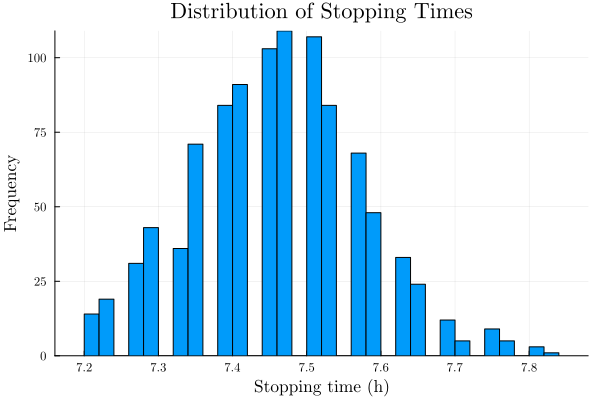

In [50]:
# 1) Define your payoff function.
#    g(s, t) = -t if s ≤ thresh, else 0.
g(s, t) = (s ≤ thresh) ? -t : 0.0

# 2) Preallocate V to store the values of the continuation value:
V = zeros(M, N)
τ = fill(N, M)  # τ[i] will hold the index of the first n at which we stop for path i, currently set to N (# of time steps)

# 3) Initialize terminal payoffs at n = N:
#    Last column of V is the payoff at time N.
#    At terminal time, Substrate is 0 and < thresh, 
#    so the value is -T, our lowest possible payoff.
for i in 1:M
    V[i, N] = g(S[i, N], tsteps[N])
end

# 4) The backward induction:
for n in (N-1):-1:1
    # 4a) Identify which paths are ITM (< threshold) at time n:
    #     might be optional, but just for the sake of clarity, OG Longstaff_Schwartz does it.
    s_now = S[:, n]
    itm_indices = findall(i -> s_now[i] ≤ thresh, 1:M)
    if length(itm_indices) < 10
        # If too few in‐the‐money paths, skip regression entirely:
        V[:, n] .= V[:, n+1]
        continue
    end

    # 4b) Build regression on those itm paths:
    #    The “target” for regression is V[itm_indices, n+1],
    #    i.e. the payoff if we _do not_ stop at n but continue.
    vf_itm = V[itm_indices, n+1]
    s_itm = s_now[itm_indices]

    #    Build your Laguerre design matrix at s_itm (degree = 3):
    Φ = laguerre_design_matrix(s_itm, degree)   # size = (#itm) × (degree+1)

    #    Solve for β by least squares:
    β = Φ \ vf_itm
    #    The “continuation value” at those S[i,n] is then Φ * β:
    continuation_value = Φ * β

    # 4c) For each itm‐path i:
    for (k, i) in enumerate(itm_indices)
        node_reward = g(s_now[i], tsteps[n])    # = –tsteps[n]
        if node_reward ≥ continuation_value[k]
            # If stopping is better than (or equal to) continuing:
            V[i, n] = node_reward
            τ[i] = n      # record “we stop here”
        else
            # Otherwise, carry forward whatever happens next:
            V[i, n] = V[i, n+1]
        end
    end

    # 4d) For all other paths (not in‐the‐money), just carry forward:
    non_itm = setdiff(1:M, itm_indices)
    V[non_itm, n] .= V[non_itm, n+1]
end

# 5) At the end, τ[i] will be the index of the first n at which
#    we decided “stop.”  If we never decided to stop earlier,
#    τ[i] will remain set to N, and V[i,1] will hold the optimal
#    (discounted) payoff from time zero.

mean_stopping_time = mean(tsteps[τ])
println("Average stopping time: ", mean_stopping_time)

# 6) Plot the results:
histogram(tsteps[τ];
    bins=30,
    xlabel="Stopping time (h)",
    ylabel="Frequency",
    title="Distribution of Stopping Times",
    legend=false,
    fontfamily="Computer Modern"
)

### Biochemical Reaction Kinetics for Malic Acid Production under Nitrogen-limited Culture (Maschmeier, 2024)

In [51]:
# # Setting up the model parameters
# # The parameters are defined in a dictionary for easy access and modification
# params  = Dict(
#     "µ_max" => 0.125, # (h⁻¹)
#     "µ2_max" => 0.125, # (h⁻¹)
#     "K_fg" => 0.147, # (g/L)
#     "K_N" => 0.1,
#     "K_fg2" => 3.277, # (g/L)
#     "K_IN" => 0.000147, # (g/L) 
#     "ϕ_X" => 1.56, 
#     "q_split_max" => 1.985, # (h⁻¹) 
#     "K_suc" => 0.00321, # (g/L)
#     "q_p_max" => 28.188, # (h⁻¹)
#     "K_p_fg" => 0.0175, # (g/L)
#     "K_IP" => 0.000147, # (g/L)
#     "Y_active_S" => 0.531, 
#     "Y_inactive_S" => 0.799,
#     "Y_ps" => 0.508,
#     "Y_active_N" => 9.428,
#     "acc" => 0.01 # (g/L)
# )

# # Initial conditions for the state variables
# # The initial conditions are defined in a dictionary for easy access and modification
# init = Dict(
#     "X_a0" => 2.0, 
#     "X_i0" => 0.0, 
#     "Suc0" => 65.0, 
#     "FG0" => 10.0, 
#     "N0" => 0.75, 
#     "P0" => 0.0
# )

# # Time parameters
# T = 40.0  # Time span for the simulation
# dt = 0.001  # Time step for the simulation
# N = Int(T / dt)  # Number of time steps
# tsteps = 0:dt:T  # Time steps array

# # Generate and solve the problem
# sol = kineticsMA(params, T, init, dt)

# X_active = sol[1, :]
# X_inactive = sol[2, :]
# Sucrose = sol[3, :]
# FG = sol[4, :]
# Ammonia = sol[5, :]
# MalicAcid = sol[6, :]

# plot(tsteps, FG, xlabel="Time (h)", ylabel="Active Biomass (g/L)", title="Active Biomass vs Time", label="X_active", lw=2)

# # Plotting the results
# plot(sol, title="Kinetics Malic Acid Simulation", label=[L"X_{active}" L"X_{inactive}" L"Sucrose" L"Fructose~Glucose" L"Ammonia" L"Malic~Acid"], xlabel="Time (h)", ylabel="Concentration (g/L)", lw=2, markersize=4, grid=true, ylims=(0, init["Suc0"]), xlims=(0, T), fontfamily="Computer Modern", legend=:topright)